Cargamos las librerías necesarias

In [40]:
#Cargo o importo pandas, numpy, Matplotlib, 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para el análisis descriptivo inicial de contraste de asociación importo el test Chi2 y el anova 
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway


# Librería para hacer la tramificación, agrupación y transformación WOE
from optbinning import Scorecard, BinningProcess, OptimalBinning
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks, ScorecardMonitoring

# Scikit-learn para dividir la muestra y para estimar el modelo de regresión logística (sólo si no se quiere utilizar
# la función optbinning.scorecard que ya lo incropora)
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

In [41]:

dt = pd.read_excel('DatosPractica_Scoring.xlsx')

In [42]:
#Información del Contenido
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        1319 non-null   int64  
 1   Cardhldr  1285 non-null   float64
 2   default   994 non-null    float64
 3   Age       1319 non-null   float64
 4   Income    1319 non-null   float64
 5   Exp_Inc   1319 non-null   float64
 6   Avgexp    1319 non-null   float64
 7   Ownrent   1319 non-null   int64  
 8   Selfempl  1319 non-null   int64  
 9   Depndt    1319 non-null   int64  
 10  Inc_per   1319 non-null   float64
 11  Cur_add   1319 non-null   int64  
 12  Major     1319 non-null   int64  
 13  Active    1319 non-null   int64  
dtypes: float64(7), int64(7)
memory usage: 144.4 KB


In [43]:
print(dt.columns)
dt = dt.rename(columns={'default': 'y'})
dt["y"].value_counts()


Index(['ID', 'Cardhldr', 'default', 'Age', 'Income', 'Exp_Inc', 'Avgexp',
       'Ownrent', 'Selfempl', 'Depndt', 'Inc_per', 'Cur_add', 'Major',
       'Active'],
      dtype='object')


y
0.0    890
1.0    104
Name: count, dtype: int64

In [44]:
dt['y'].value_counts(normalize=True)

y
0.0    0.895372
1.0    0.104628
Name: proportion, dtype: float64

In [45]:
# Guardo los valores para su uso posterior 
yT_0 = dt['y'].value_counts(normalize=True)[0]
yT_1 = dt['y'].value_counts(normalize=True)[1]
print(yT_0, yT_1)

0.8953722334004024 0.10462776659959759


In [ ]:
dt = dt.drop(columns=["Exp_Inc", "Inc_per"])

# -------------------------------
# 1. Clientes aceptados (Cardhldr = 1 y Default conocido)
dt_aceptados = dt[(dt["Cardhldr"] == 1) & (dt["y"].notna())].copy()

# -------------------------------
# 2. Clientes rechazados (Cardhldr = 0)
dt_rechazados = dt[dt["Cardhldr"] == 0].copy()
dt_rechazados["y"] = -1  # marcador para default no observado

# -------------------------------
# 3. Nuevos clientes (Cardhldr = NaN y ID entre 1286 y 1319)
dt_nuevos = dt[dt["ID"].between(1286, 1319)].copy()


# Verificar tamaños
print("Aceptados:", dt_aceptados.shape)
print("Rechazados:", dt_rechazados.shape)
print("Nuevos:", dt_nuevos.shape)



Aceptados: (994, 12)
Rechazados: (291, 12)
Nuevos: (34, 12)


In [51]:
ids_aceptados = dt_aceptados['ID']
ids_rechazados = dt_rechazados['ID']
ids_Nuevos = dt_nuevos['ID']



# Eliminar la columna ID del dataset principal para el modelado
dt_aceptadosm = dt_aceptados.drop(columns=['ID'])
ids_rechazadosm = dt_rechazados.drop(columns=['ID'])
ids_Nuevosm = dt_nuevos.drop(columns=['ID'])

<class 'pandas.core.frame.DataFrame'>
Index: 994 entries, 0 to 1284
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Cardhldr  994 non-null    float64
 1   y         994 non-null    float64
 2   Age       994 non-null    float64
 3   Income    994 non-null    float64
 4   Avgexp    994 non-null    float64
 5   Ownrent   994 non-null    int64  
 6   Selfempl  994 non-null    int64  
 7   Depndt    994 non-null    int64  
 8   Cur_add   994 non-null    int64  
 9   Major     994 non-null    int64  
 10  Active    994 non-null    int64  
dtypes: float64(5), int64(6)
memory usage: 93.2 KB
None

Valores nulos por columna:
 Cardhldr    0
y           0
Age         0
Income      0
Avgexp      0
Ownrent     0
Selfempl    0
Depndt      0
Cur_add     0
Major       0
Active      0
dtype: int64

Estadísticas descriptivas:
        Cardhldr           y         Age      Income       Avgexp     Ownrent  \
count     994.0  994.000000  99

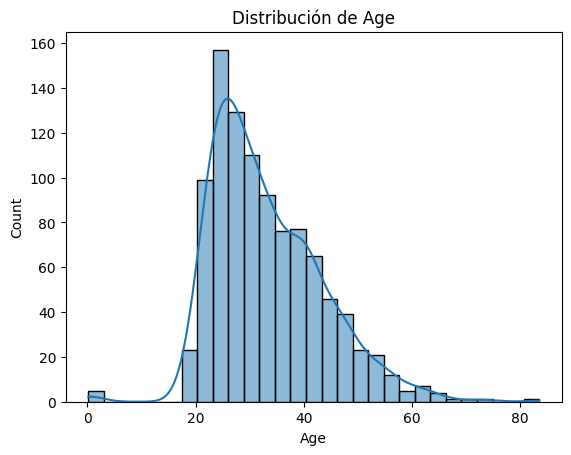

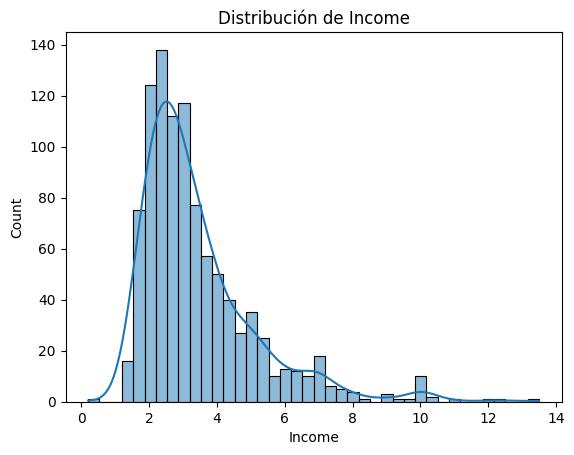

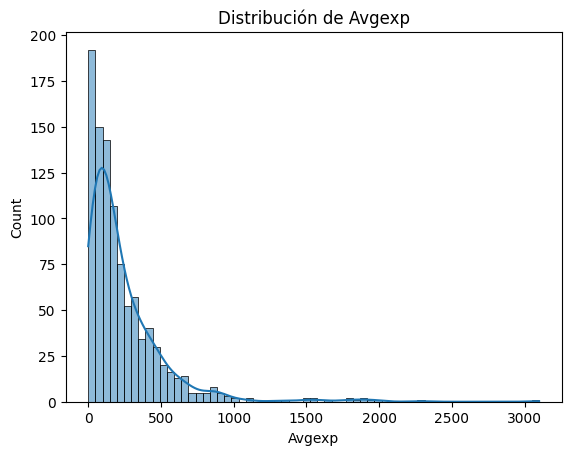

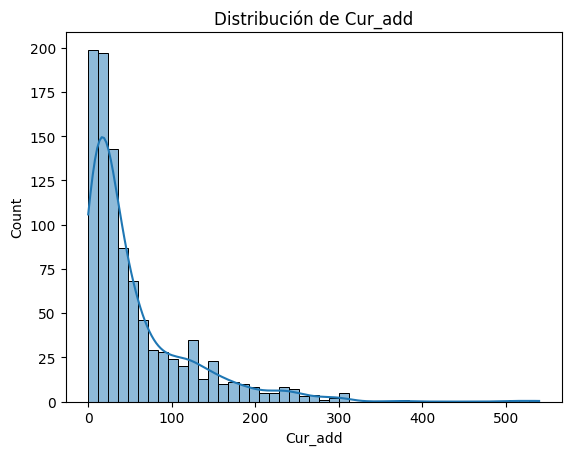

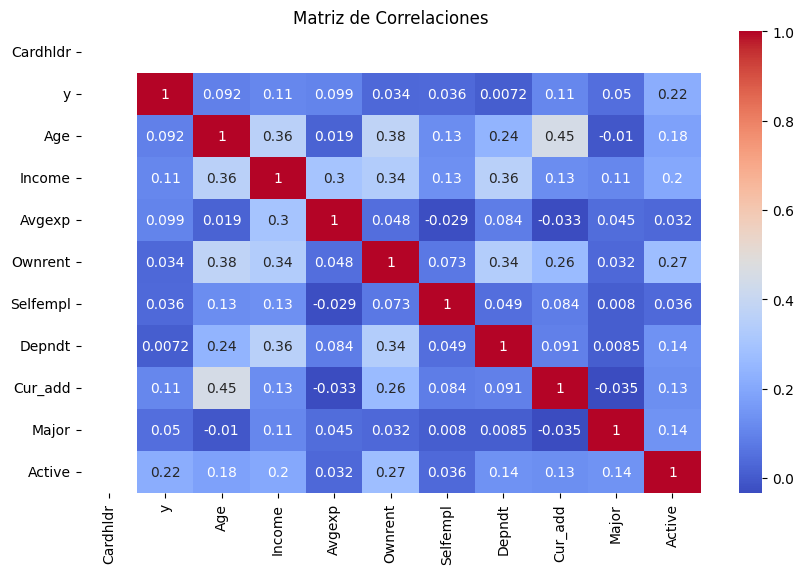

In [52]:
# 1. Revisión general
print(dt_aceptadosm.info())
print("\nValores nulos por columna:\n", dt_aceptadosm.isna().sum())

# 2. Estadísticas descriptivas
print("\nEstadísticas descriptivas:\n", dt_aceptadosm.describe())

# 3. Variables con baja variabilidad (casi todos los valores iguales)
low_variance = dt_aceptadosm.nunique()
print("\nVariables con poca variabilidad:\n", low_variance[low_variance <= 2])

# 4. Distribuciones de variables numéricas
num_cols = ['Age', 'Income', 'Avgexp', 'Cur_add']
for col in num_cols:
    plt.figure()
    sns.histplot(dt_aceptadosm[col], kde=True)
    plt.title(f"Distribución de {col}")
    plt.show()

# 5. Matriz de correlaciones
plt.figure(figsize=(10,6))
sns.heatmap(dt_aceptadosm.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Matriz de Correlaciones")
plt.show()

In [53]:
for col in ['Ownrent', 'Selfempl', 'Major']:
    dt_aceptadosm[col].fillna(dt_aceptadosm[col].mode()[0], inplace=True)

for col in ['Ownrent', 'Selfempl', 'Major']:
    ids_rechazadosm[col].fillna(ids_rechazadosm[col].mode()[0], inplace=True)


C:\Users\jfdr1\AppData\Local\Temp\ipykernel_16240\3928515790.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dt_aceptadosm[col].fillna(dt_aceptadosm[col].mode()[0], inplace=True)
C:\Users\jfdr1\AppData\Local\Temp\ipykernel_16240\3928515790.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

***


In [54]:
dt_train, dt_test = train_test_split(dt_aceptadosm,stratify=dt_aceptadosm["y"], test_size=.25, random_state=1234)

In [56]:
dt_train["y"].mean().round(2)

np.float64(0.1)

In [ ]:
dt_test["y"].mean().round(2)

np.float64(0.1)

In [57]:
Y = dt_aceptadosm['y'].values

# Variables predictoras (quitamos también 'Cardhldr' ya que no aporta al modelo)
X = dt_aceptadosm.drop(columns=['y', 'Cardhldr'])

# Lista con todas las variables predictoras
list_variables = X.columns.tolist()

# Variables categóricas (discretas / binarias / ordinales, son tipo int en tu dataset)
list_categorical = ['Ownrent', 'Selfempl', 'Depndt', 'Major', 'Active']

# Variables numéricas (tipo float64 en tu dataset)
list_numerical = ['Age', 'Income', 'Avgexp', 'Cur_add']

# Confirmación visual
print("Variables predictoras:", list_variables)
print("Variables categóricas:", list_categorical)
print("Variables numéricas:", list_numerical)

Variables predictoras: ['Age', 'Income', 'Avgexp', 'Ownrent', 'Selfempl', 'Depndt', 'Cur_add', 'Major', 'Active']
Variables categóricas: ['Ownrent', 'Selfempl', 'Depndt', 'Major', 'Active']
Variables numéricas: ['Age', 'Income', 'Avgexp', 'Cur_add']


In [58]:
# 2) Definimos el criterio de selección
selection_criteria = {
    "iv": {"min": 0.02} # no aplicamos "max": 1}
}

binning_fit_params={
    "purpose":{"cat_cutoff": 0.10}
}

# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria,
    binning_fit_params=binning_fit_params)

# 4) Obtenemos los tramos optimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)

### Este es el resultado de esta primera parte de tramificación y selección de variables explicativas 
dt_train_binned.summary().sort_values('iv')


c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
4,Selfempl,categorical,OPTIMAL,False,2,0.011895,0.001478,0.028111,0.005643
3,Ownrent,categorical,OPTIMAL,False,2,0.011976,0.001496,0.054689,0.02354
5,Depndt,categorical,OPTIMAL,True,4,0.020308,0.002529,0.065493,0.001561
7,Major,categorical,OPTIMAL,True,2,0.030557,0.003792,0.059399,0.039958
6,Cur_add,numerical,OPTIMAL,True,6,0.192857,0.023537,0.232347,0.002619
1,Income,numerical,OPTIMAL,True,5,0.222999,0.026768,0.215741,0.055953
0,Age,numerical,OPTIMAL,True,7,0.224977,0.026616,0.236603,0.021707
2,Avgexp,numerical,OPTIMAL,True,7,0.271663,0.031598,0.243863,0.018436
8,Active,categorical,OPTIMAL,True,10,1.029835,0.112974,0.496608,0.0


In [59]:
# Estimamos el modelo con la regresión logística directamente con el método que incorpora directamente el objeto Scorecard

estimator = LogisticRegression(solver="lbfgs")

# Establecemos los parámetros para la transformación de probabilidades en puntos de calidad crediticia o score

pdo_0 =40
scorecard_points_0= 600 
odds_0_B= 50 # (equivalente a  odds_0 =1/50 )

tarjeta= Scorecard(binning_process=binning_process,
                   estimator=estimator,
                   scaling_method="pdo_odds",
                   scaling_method_params={"pdo":pdo_0, "odds": odds_0_B, "scorecard_points": scorecard_points_0})

tarjeta.fit(X, Y, show_digits=4)

c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

Scorecard(binning_process=BinningProcess(binning_fit_params={'purpose': {'cat_cutoff': 0.1}},
                                         categorical_variables=['Ownrent',
                                                                'Selfempl',
                                                                'Depndt',
                                                                'Major',
                                                                'Active'],
                                         selection_criteria={'iv': {'min': 0.02}},
                                         variable_names=['Age', 'Income',
                                                         'Avgexp', 'Ownrent',
                                                         'Selfempl', 'Depndt',
                                                         'Cur_add', 'Major',
                                                         'Active']),
          estimator=LogisticRegression(), scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 40,
                                 'scorecard_points': 600})

In [60]:
# obtenmos las predicciones de probabilidad
Y_pred=tarjeta.predict_proba(X)[:,1]

# Calculamos la media
Y_pred.mean().round(5)


np.float64(0.10457)

c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


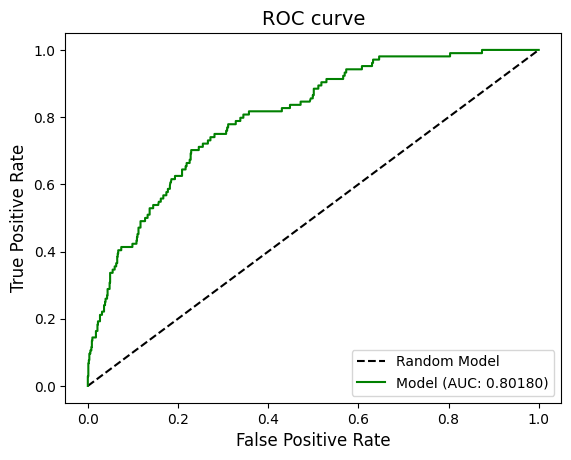

In [61]:
# Diagnosis Curva ROC
plot_auc_roc(Y,Y_pred)

c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


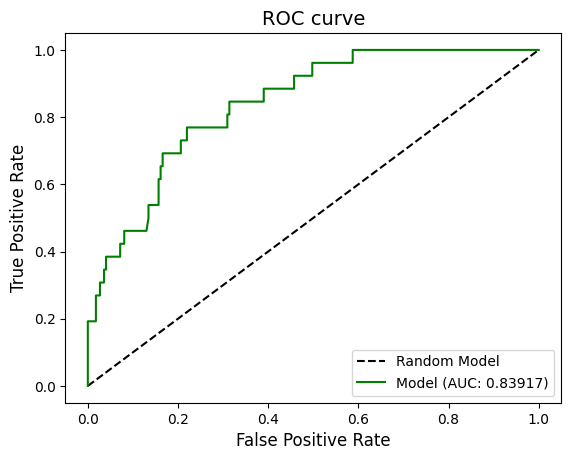

In [62]:
Y_test = dt_test['y'].values
X_test = dt_test.drop(columns=['y']) #todas menos la variable y
Y_test_pred=tarjeta.predict_proba(X_test)[:,1]
# Diagnosis Curva ROC
plot_auc_roc(Y_test,Y_test_pred)

In [63]:
Prob_Corte=Y.mean()
print(Prob_Corte)

0.10462776659959759


In [64]:
X_rechazados = ids_rechazadosm
Y_rechazados_pred=tarjeta.predict_proba(X_rechazados)[:,1]
dt_rechazados["y"]=np.multiply(Y_rechazados_pred>Prob_Corte,1)

In [65]:
print(dt_rechazados["y"].value_counts(normalize=True))

y
0    0.824742
1    0.175258
Name: proportion, dtype: float64


In [66]:
X_Nuevos = ids_Nuevosm 
Y_Nuevos_pred=tarjeta.predict_proba(X_Nuevos)[:,1]
dt_nuevos["Prob_Sinrechazados"]=np.multiply(Y_Nuevos_pred,1)
dt_nuevos["y_Sinrechazados"]=np.multiply(Y_Nuevos_pred>Prob_Corte,1)

In [67]:
dt2=pd.concat([dt_aceptadosm,ids_rechazadosm], axis=0)
dt2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1285 entries, 0 to 1281
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Cardhldr  1285 non-null   float64
 1   y         1285 non-null   float64
 2   Age       1285 non-null   float64
 3   Income    1285 non-null   float64
 4   Avgexp    1285 non-null   float64
 5   Ownrent   1285 non-null   int64  
 6   Selfempl  1285 non-null   int64  
 7   Depndt    1285 non-null   int64  
 8   Cur_add   1285 non-null   int64  
 9   Major     1285 non-null   int64  
 10  Active    1285 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 120.5 KB


In [68]:
dt2['y'].value_counts()

y
 0.0    890
-1.0    291
 1.0    104
Name: count, dtype: int64

In [69]:
dt2['y'].value_counts(normalize=True)

y
 0.0    0.692607
-1.0    0.226459
 1.0    0.080934
Name: proportion, dtype: float64

In [72]:
dt2_modelo = dt2[dt2['y'].isin([0.0, 1.0])].copy()


In [74]:
### Dividimos la muestra en entrenamiento y test
dt_train, dt_test = train_test_split(dt2_modelo,stratify=dt2_modelo["y"], test_size=.25, random_state=1234)
print(dt_train["y"].mean(),dt_test["y"].mean())
### Defino la tramificación óptima

# 1) Definimos la lista de nombres señalando cuales de ellas son las categóricas
Y = dt_train['y'].values
X = dt_train.drop(columns=['y']) #todas menos la variable y

list_variables = X.columns.values.tolist()
list_categorical = ['Ownrent', 'Selfempl', 'Depndt', 'Major', 'Active']
list_numerical = ['Age', 'Income', 'Avgexp', 'Cur_add']

# 2) Definimos el criterio de selección
selection_criteria = {
    "iv": {"min": 0.02} #, "max": 1}
}
# En caso de que desee modificarse los valores por defecto en el proceso de tramificación de alguna variable puede hacerse en forma de diccionario

binning_fit_params={
    "purpose":{"cat_cutoff": 0.10}
}

# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria,
    binning_fit_params=binning_fit_params)

# 4) Obtenemos los tramos optimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)
dt_train_binned.summary().sort_values('iv')

0.10469798657718121 0.10441767068273092


c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,Cardhldr,numerical,OPTIMAL,False,1,0.0,0.0,0,0.0
4,Ownrent,categorical,OPTIMAL,False,2,0.004974,0.000622,0.035232,0.00612
8,Major,categorical,OPTIMAL,False,2,0.016134,0.002009,0.043536,0.016039
5,Selfempl,categorical,OPTIMAL,False,2,0.019567,0.002422,0.035771,0.009448
6,Depndt,categorical,OPTIMAL,True,4,0.034875,0.004338,0.094722,0.010048
7,Cur_add,numerical,OPTIMAL,True,5,0.165855,0.020396,0.211702,0.029017
1,Age,numerical,OPTIMAL,True,6,0.205791,0.024826,0.227771,0.033651
2,Income,numerical,OPTIMAL,True,5,0.235324,0.02751,0.180448,0.114868
3,Avgexp,numerical,OPTIMAL,True,6,0.246,0.028613,0.227175,0.141
9,Active,categorical,OPTIMAL,True,11,1.100557,0.119359,0.517453,0.0


In [75]:
# Directamente con el método Scorecard
estimator = LogisticRegression(solver="lbfgs")

# Establecemos los parámetros para la transformación de probabilidades en puntos de calidad crediticia o score

pdo_0 =40
scorecard_points_0= 600 
odds_0_B= 50 # (equivalente a  odds_0 =1/50 )

tarjeta= Scorecard(binning_process=binning_process,
                   estimator=estimator,
                   scaling_method="pdo_odds",
                   scaling_method_params={"pdo":pdo_0, "odds": odds_0_B, "scorecard_points": scorecard_points_0})

tarjeta.fit(X, Y, show_digits=4)

c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

Scorecard(binning_process=BinningProcess(binning_fit_params={'purpose': {'cat_cutoff': 0.1}},
                                         categorical_variables=['Ownrent',
                                                                'Selfempl',
                                                                'Depndt',
                                                                'Major',
                                                                'Active'],
                                         selection_criteria={'iv': {'min': 0.02}},
                                         variable_names=['Cardhldr', 'Age',
                                                         'Income', 'Avgexp',
                                                         'Ownrent', 'Selfempl',
                                                         'Depndt', 'Cur_add',
                                                         'Major', 'Active']),
          estimator=LogisticRegression(), scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 40,
                                 'scorecard_points': 600})

In [76]:
Y_pred=tarjeta.predict_proba(X)[:,1]

# Calculamos la media
Y_pred.mean().round(5)

np.float64(0.10468)

c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jfdr1\anaconda\envs\mineria\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


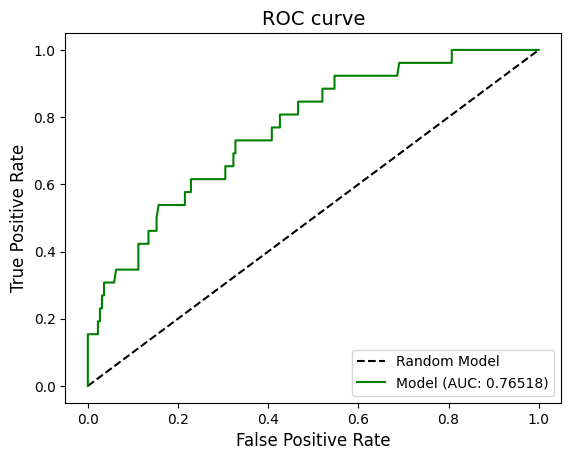

In [77]:
Y_test = dt_test['y'].values
X_test = dt_test.drop(columns=['y']) #todas menos la primera que es el ID y la variable y

Y_test_pred=tarjeta.predict_proba(X_test)[:,1]

# Diagnosis Curva ROC
plot_auc_roc(Y_test,Y_test_pred)

In [78]:
X_rechazados = ids_rechazadosm
Y_rechazados_pred=tarjeta.predict_proba(X_rechazados)[:,1]
ids_rechazadosm["y"]=np.multiply(Y_rechazados_pred>Prob_Corte,1)

print(ids_rechazadosm["y"].value_counts(normalize=True))



y
0    0.735395
1    0.264605
Name: proportion, dtype: float64
